In [176]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import random
import torch
from torchvision import transforms as T
import torch.nn.functional as F
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Model Inference

In [177]:
bird_class_map = {
    0: "Black Stilt",
    1: "Bonelli’s Eagle",
    2: "Brahminy Kite",
    3: "Common Bronzewing",
    4: "Common Myna",
    5: "Great Tit",
    6: "Hill Pigeon",
    7: "Himalayan Bulbul",
    8: "Himalayan Griffon",
    9: "House Sparrow",
    10: "Indian Vulture",
    11: "Jungle Owlet",
    12: "Long-billed Crow",
    13: "Magpie Robin",
    14: "Red-billed Magpie",
    15: "White-crested Laughingthrush"
}

bird_class_map_short = {
    "blasti": "Black Stilt",
    "bonegl": "Bonelli’s Eagle",
    "brhkyt": "Brahminy Kite",
    "cbrtsh": "Common Bronzewing",
    "cmnmyn": "Common Myna",
    "gretit": "Great Tit",
    "hilpig": "Hill Pigeon",
    "himbul": "Himalayan Bulbul",
    "himgri": "Himalayan Griffon",
    "hsparo": "House Sparrow",
    "indvul": "Indian Vulture",
    "jglowl": "Jungle Owlet",
    "lbicrw": "Long-billed Crow",
    "mgprob": "Magpie Robin",
    "rebimg": "Red-billed Magpie",
    "wcrsrt": "White-crested Laughingthrush"
}


image 1/1 /home/alex-kravchuk/MyCodeProjects/MA_lab3/bird-dataset/val/indvul/DSC_1275.jpg: 224x224 indvul 0.33, himgri 0.31, himbul 0.07, lbicrw 0.07, brhkyt 0.04, 1.1ms
Speed: 63.4ms preprocess, 1.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /home/alex-kravchuk/MyCodeProjects/MA_lab3/bird-dataset/val/himbul/_D32_10251.jpg: 224x224 himbul 0.21, cmnmyn 0.15, himgri 0.15, indvul 0.11, lbicrw 0.07, 1.1ms
Speed: 8.9ms preprocess, 1.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /home/alex-kravchuk/MyCodeProjects/MA_lab3/bird-dataset/val/wcrsrt/100_4464.JPG: 224x224 wcrsrt 0.31, hsparo 0.23, gretit 0.07, himgri 0.05, rebimg 0.05, 1.1ms
Speed: 16.6ms preprocess, 1.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /home/alex-kravchuk/MyCodeProjects/MA_lab3/bird-dataset/val/mgprob/100_5811.JPG: 224x224 himbul 0.33, wcrsrt 0.15, mgprob 0.08, jglowl 0.08, himgri 0.06, 1.1ms
Speed: 17.0ms preprocess

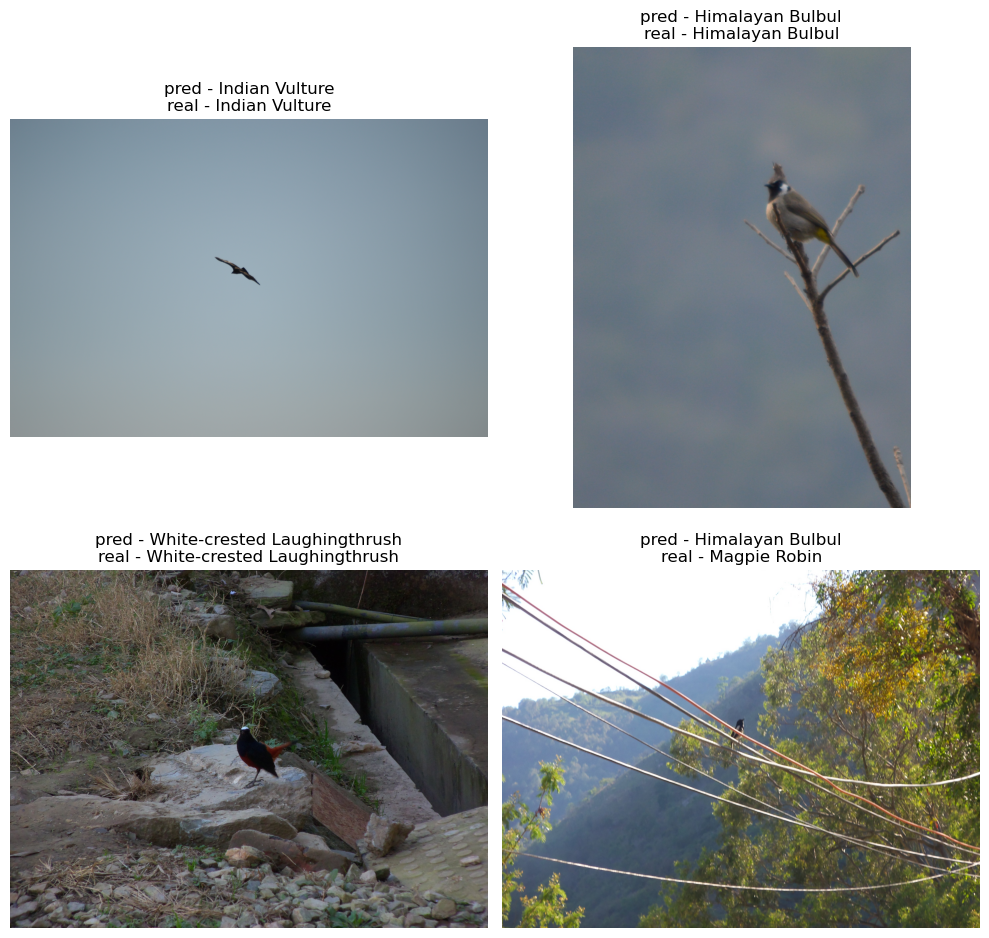

In [184]:
test_dir = 'bird-dataset/val'
model = YOLO('best.pt')
model = model.to(device)

all_images = []
for cls in os.listdir(test_dir):
    cls_path = os.path.join(test_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    imgs = [os.path.join(cls_path, img) for img in os.listdir(cls_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img in imgs:
        all_images.append((img, cls))

samples = random.sample(all_images, 4)

plt.figure(figsize=(10, 10))

for idx, (img_path, real_cls) in enumerate(samples):

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    result = model(img_path, task='classify', imgsz=224)
    pred_idx = int(result[0].probs.top1)
    pred_label = bird_class_map[pred_idx]
    real_label = bird_class_map_short[real_cls]

    plt.subplot(2, 2, idx + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f'pred - {pred_label}\nreal - {real_label}', fontsize=12)

plt.tight_layout()
plt.show()

### Attack

Image for attack


image 1/1 /home/alex-kravchuk/MyCodeProjects/MA_lab3/bird-dataset/val/indvul/DSC_1275.jpg: 224x224 indvul 0.33, himgri 0.31, himbul 0.07, lbicrw 0.07, brhkyt 0.04, 1.2ms
Speed: 69.8ms preprocess, 1.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


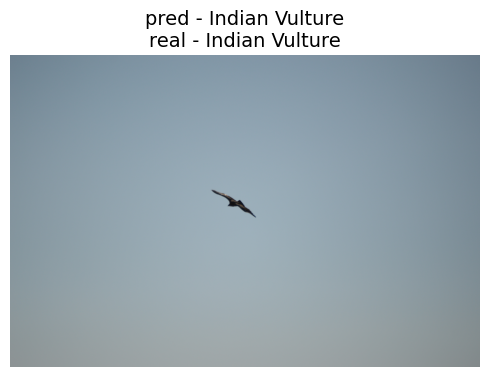

In [179]:
img_path, real_cls = random.choice(all_images)

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = model(img_path, task='classify')
pred_idx = int(result[0].probs.top1)
pred_label = bird_class_map[pred_idx]
real_label = bird_class_map_short[real_cls]

plt.figure(figsize=(5, 5))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f'pred - {pred_label}\nreal - {real_label}', fontsize=14)
plt.tight_layout()
plt.show()

Projected Gradient Descent algorithm

In [181]:
def diff_yolo_preprocess(x, *, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    b, c, h, w = x.shape
    if h > w:
        new_h, new_w = 224, int(w * 224 / h)
    else:
        new_h, new_w = int(h * 224 / w), 224
    x = F.interpolate(x, size=(new_h, new_w), mode="bilinear", align_corners=False)
    pad_h, pad_w = 224 - new_h, 224 - new_w
    top, bottom = pad_h // 2, pad_h - pad_h // 2
    left, right = pad_w // 2, pad_w - pad_w // 2
    x = F.pad(x, (left, right, top, bottom))
    mean_t = torch.tensor(mean, device=x.device, dtype=x.dtype).view(1, 3, 1, 1)
    std_t = torch.tensor(std, device=x.device, dtype=x.dtype).view(1, 3, 1, 1)
    return (x - mean_t) / std_t


def pgd_attack(model, x, y_true,
               eps=8/255, alpha=2/255, n_iter=40,
               clamp_min=0.0, clamp_max=1.0):

    x = x.clone().detach()
    delta = torch.empty_like(x).uniform_(-eps, eps)
    delta = torch.clamp(x + delta, clamp_min, clamp_max) - x
    delta.requires_grad = True

    for _ in range(n_iter):
        out = model(diff_yolo_preprocess(x + delta))
        logits = out[0] if isinstance(out, (list, tuple)) else out

        loss = torch.nn.functional.cross_entropy(logits, y_true)
        loss.backward()

        delta.data += alpha * delta.grad.sign()
        delta.data = torch.clamp(delta, -eps, eps)
        delta.data = torch.clamp(x + delta.data, clamp_min, clamp_max) - x
        delta.grad.zero_()

    return (x + delta).detach()

The attack

In [182]:
real_idx = {v: k for k, v in bird_class_map.items()}[real_label]
y_true = torch.tensor([real_idx], device=device)

x_orig = torch.as_tensor(img_rgb, dtype=torch.float32, device=device)
x_orig = x_orig.permute(2, 0, 1).unsqueeze(0) / 255.0

net = model.model.to(device).eval()
x_adv = pgd_attack(
    net, x_orig, y_true, eps=10/255, alpha=5/255, n_iter=100
)

Checking the result on images with original shape before any transformations


0: 224x224 himgri 0.27, indvul 0.24, lbicrw 0.10, himbul 0.07, blasti 0.05, 1.1ms
Speed: 63.9ms preprocess, 1.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
(4000, 6016, 3)

0: 224x224 himgri 0.26, indvul 0.24, lbicrw 0.11, himbul 0.08, blasti 0.05, 1.1ms
Speed: 65.4ms preprocess, 1.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


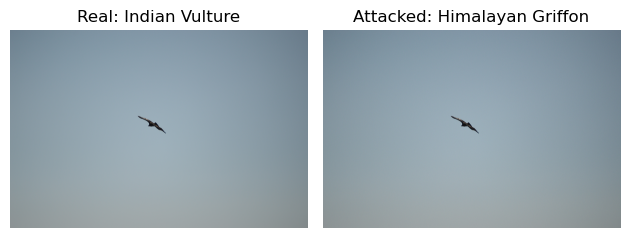

In [183]:
with torch.no_grad():
    results = model(img_rgb)
    pred_clean = int(result[0].probs.top1)

    adv_np = (
        x_adv.squeeze().cpu().permute(1, 2, 0).numpy().clip(0, 1) * 255
    ).astype(np.uint8)
    print(adv_np.shape)
    results_adv = model(adv_np)
    pred_adv = int(results_adv[0].probs.top1)

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Real: {bird_class_map[pred_clean]}")

plt.subplot(1, 2, 2)
plt.imshow(adv_np)
plt.axis('off')
plt.title(f"Attacked: {bird_class_map[pred_adv]}")

plt.tight_layout()
plt.show()